In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

# SciPy-related functions
from scipy.stats import multivariate_normal, exponnorm, norm
from scipy.special import erf, erfc 
from scipy.stats.qmc import PoissonDisk

# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

# Ensure repearable randomness
RNG = np.random.default_rng(2024)

# Group Attention Simulator for Immersive Rooms

This notebook describes an exploratory simulator that captures the attentional distribution in immersive rooms using a physically-based model of human agent movement. Although the simulator will be eventually incorporated in the Unity game engine, the mathematical definition of agent attention is best prototyped in isolation using NumPy. Therefore, to help clarifying thoughts, I will describe here in mathematical terms how agent attention is represented in the immersive room, and how the movement of agent group is imprinted as the room's attentional memory.

### Part 0: Some Background

The starting point of this simulator comes from the theory of proxemics, proposed in Edward T. Hall's [*The Hidden Dimension*](https://archive.org/details/hiddendimensionhall00hall/page/n9/mode/2up). In his book, he specified a series of distance-based measures that thresholds the spatial boundaries of human interactions. This has inspired some coarse simulation of human agent behavior in early developments of physically-realistic virtual environment (see [Yan and Kalay, 2006](https://link.springer.com/chapter/10.1007/978-1-4020-5131-9_4)). Here, we adopt it conceptually as a toy model, with some variations.

For this simulator, we do not seek to replicate exactly the distance thresholds outlined in these works. Instead, to account for individual differences in the future, we treat these thresholds more liberally. We interpret attention as *the probability that an agent would physically interact with a surrounding target based upon where the agent is located and oriented*. The attention of these agents can then be modeled as a continuous probability distribution in space. Optionally, the discrete thresholds can be used as data points for model fitting.

### Part 1: Agent Representation

We first consider the 2D geometries of agents in the room (seen from the top) as the basis of agent representation. The room has a pre-defined interaction boundary $\Omega$ that constrains its physical dimensions. Let $a = 1, 2, ..., A$ be the agents present in the immersive room. They each have positions $\mathbf{x}_a = (x_a, y_a)$ and orientations $\theta_a$. These parameters allow us to create two types of agent-based attentional distributions in the room, $w_a$:

<p align="center"><img src="../assets/attentional_weights.png" width="400"></p>

1) Proximity-based attentional weight, $w(x, y)$. This is a function of attentional probability based solely on how closely gathered agents are, as per Hall's original theory. For each agent $a$, this can be represented as a 2D spherical Gaussian distribution in the room:

$$
\begin{equation}
    w_a(x, y) = \exp \left(-\frac{(x - x_a)^2 + (y - y_a)^2}{2\sigma_a^2} \right).
\end{equation}
$$

In [6]:
# Proximity-based attentional weight
def proximity_based_weight(base, mu, sigma=1):
    """
    Proximity-based attentional_weight. 
    This is done in deterministic calculation.

    Parameters:
    -----------
    position    : array-like
        Spatial positions of the agent as the mean of this weight in space.

    spread      : array-like
        Distance-based spread of the weight as spherical covariance matrix.

    Returns:
    -----------
    Attentional weight of a single agent in free space based solely upon proximity.
    """
    return multivariate_normal(mu, sigma).pdf(base)

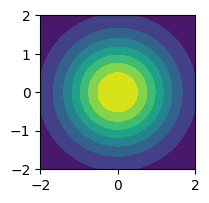

In [27]:
# Visualizing proximity-based attentional weight for a single agent

# Define physical dimension and granularity of spatial discretization
l, w = np.array([4., 4.])
hl, hw = l/2, w/2
d = 0.05

# Create a data grid for the footprint
x, y = np.mgrid[-hl:hl+d:d, -hw:hw+d:d]
grid = np.dstack((x, y))

# Generate agent positions
weight = proximity_based_weight(grid, mu=[0, 0])

# Plotting this
f, ax = plt.subplots(1, 1, figsize=(hl, hw))
f = plt.contourf(x, y, weight)


2) Orientation-based attentional weight, $w(x, y, r, \theta)$. This is a function based on both the agents' distances and their orientations. Different from the proximity-based attentional weight, this attentional weight is biased towards the front side of the agent, where peripheral information on the back side contributes less. 

$$
\begin{equation}
    w_a(x, y, r, \theta) = \exp \left(-\frac{(x - x_a - r \cos \theta_a)^2 + (y - y_a - r \sin \theta_a)^2}{2\sigma_a^2} \right).
\end{equation}
$$

where

$$
\begin{equation}
    r(z) = 1 - z, \quad z \in [0, 1].
\end{equation}
$$

Note: $z$ is on the same axis as $w_a$. although this weight is visually intuitive, the exact mathematical formulation here is not very clear. As a placeholder, I will use exponentially-modified normal distribution, for now.

In [ ]:
# Orientation-based attention weight:
def orientation_based_weight(base, position, spread=1):
    """
    
    """
    
    return weight

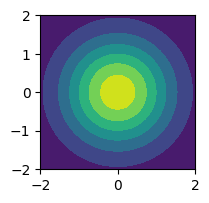

In [ ]:
# Visualizing proximity-based attentional weight for a single agent

# Define physical dimension and granularity of spatial discretization
l, w = np.array([4., 4.])
hl, hw = l/2, w/2
d = 0.05

# Create a data grid for the room's footprint
x, y = np.mgrid[-hl:hl+d:d, -hw:hw+d:d]
grid = np.dstack((x, y))

# Generate agent positions
weight = orientation_based_weight(grid, position=[0, 0])

# Plotting this
f, ax = plt.subplots(1, 1, figsize=(hl, hw))
f = plt.contourf(x, y, weight)

The imprint of these attention distribution can be seen as as a Gaussian mixture:

$$
\begin{equation}
    w(x, y) = \sum_a w_a(x, y)
\end{equation}
$$

We use Poisson disc sampling as the initial condition for the agents' attention distribution in the room, implemented below.

In [9]:
def sample_multiple_agent_positions(radius=0.5, N=24):
    from scipy.stats.qmc import PoissonDisk
    """
    Get multiple agent positions in random, using the Poisson Disc method.

    Parameters:
    -----------
    radius  : float
        Distance between each agent position.

    N       : int
        Maximum number of agent positions.

    Returns:
    -----------
    An array of agent positions.
    """
    engine = PoissonDisk(2, radius=radius)
    return engine.random(N)
    
def sample_proximal_weights(base, positions, spread=1):
    """
    Generate a map of weight that represents the spatial distribution of 
    proximity between agents as a Gaussian mixture.

    Parameters:
    -----------
    base        : array-like
        Spatial grid of the room.

    positions   : array-like
        Sampled array of agent positions.

    spread      : int
        Scale factor of spatial attentional variance for each agent.

    Returns:
    -----------
    A spatial distribution of attentional weight.
    """
    weights = np.zeros(base.shape[:2])
    for p in positions:
        weights += proximity_based_weight(base, p, np.eye(2) * spread)
    return weights / positions.shape[0]

The contour plot below shows the attentional distribution in ROIS as a snapshot.

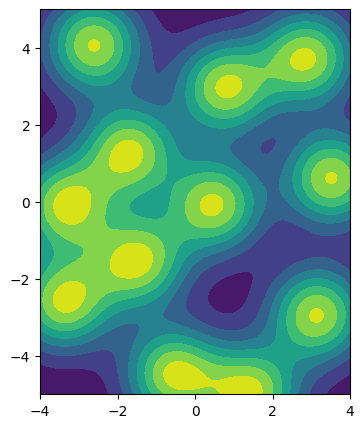

In [65]:
# Visualizing the attentional weights

# Define physical dimension and granularity of spatial discretization
l, w = np.array([8., 10.])
hl, hw = l/2, w/2
d = 0.05

# Create a data grid for the footprint
x, y = np.mgrid[-hl:hl+d:d, -hw:hw+d:d]
grid = np.dstack((x, y))

# Generate agent positions
positions = sample_multiple_agent_positions(radius=0.25) * (l, w) - (hl, hw)
proximal_weights = sample_proximal_weights(grid, positions, spread=0.75)

# Plotting this
f, ax = plt.subplots(1, 1, figsize=(hl, hw))
f = plt.contourf(x, y, proximal_weights)

### Part 2: Agent Movement

For agent simulation, two stages are currently planned. For the simplest simulation of agent movement, we use a simple multi-point attractor framework. The agents simply walk directly to the object closest to them.

In [60]:
def attract(agent_positions, object_positions, bound, dt = 0.001, max_time = 1.):
    from scipy.spatial import distance
    """
    A simple attractor framework for simulating agent movement. 

    Parameters:
    -----------
    agent_positions : np.array
        An array of agent positions.
    
    object_positions : np.array
        An array of object positions.

    dt : float
        Time interval per update.
    
    max_time : float
        Duration of simulation.
    
    Returns:
    --------
    new_agent_positions : np.array
        An array of agent positions at the end of the simulation.
    """

    # Get the count of agent and objects
    num_agents, num_objects = agent_positions.shape[0], object_positions.shape[0]
    new_agent_positions = agent_positions.copy()

    # Initialize a NumPy array of distances and angles
    distances = np.zeros((num_agents, num_objects))
    target_ids = np.zeros(num_agents, dtype=np.int16)

    t = 0.
    # I will vectorize / refactor this later.
    while t < max_time:

        # Compute distances
        for a in range(num_agents):
            for b in range(num_objects):
                distances[a,b] = distance.euclidean(agent_positions[a], object_positions[b])
                
                # Identify targets for each agent
                target_ids[a] = np.argmin(distances[a])
            
                #Update positions
                if np.abs(new_agent_positions[a, 0]) <= bound[0] and np.abs(new_agent_positions[a, 1]) <= bound[1]:
                    new_agent_positions[a] += np.subtract(object_positions[target_ids[a]], agent_positions[a]) * dt
    
        t += dt
    return new_agent_positions

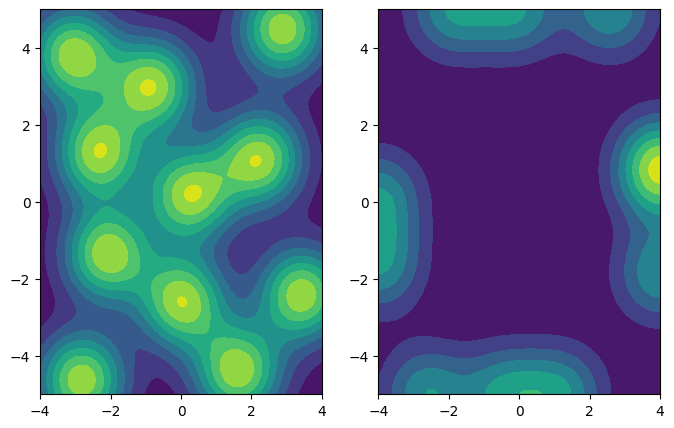

In [78]:
agent_starts = sample_multiple_agent_positions(radius=0.25) * (l, w) - (hl, hw)
objects = np.array([[1., 8.], [7., 1.], [-1., -8.], [-7., -2.]])

agent_ends = attract(agent_starts, objects, bound=[4, 5])

start_weights = sample_proximal_weights(grid, agent_starts, spread=0.75)
end_weights = sample_proximal_weights(grid, agent_ends, spread=0.75)

# Plotting this
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*hl, hw))
ax1.contourf(x, y, start_weights)
ax2.contourf(x, y, end_weights)

(Can this be turned into a 2D random walk?)

For a naive simulation of agent movement, we use a modified version of Craig Reynold's original simulation of boids (currently being implemented in tinkers, not done yet). This is also suggested in the Yan and Kalay literature. 

(Need to ask Stefan about good ways to make animations.)

### Part 3: Clustering

We can use K-mean clustering to extract attentional agent groups. However, K-mean clustering does not take into account the variance of the clusters. This means that we cannot accurately describe the size of these clusters, which is important when we try to assess how many people are within a cluster. Instead, the more appropriate clustering algorithm would be the [expectation-maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#Gaussian_mixture) for a Gaussian mixture model.

Before we continue, let us address one of the challenges facing the clustering problem at hands. In Part 1, we have already formed agent representation $a = 1, 2, ..., A$. If we solely rely on agent representation $a$, where $0 < a < 49$ in our problem setting, then we should expect poor results based upon a coarse data resolution within the sample space $\Omega$. However, because we have an attentional weight $w_a$, we can use it to resample more data points that helps with a more accurate clustering.  

### Part 4: Trajectory Simulation

Comparing trajectories using [dynamic time warping (DTW)](https://academic.oup.com/jrsssc/article/67/5/1147/7058405?login=false) algorithm.